In [1]:
library(sf)
library(ggplot2)
library(tidyverse)
library(tibble)
library(magrittr)
library(redist)
library(sp)
library(spData)
library(spdep)
library(igraph)

ff_2015_file <- "C:/Users/madie/OneDrive/data/pre-redist/VA_precinct_2015_fairfax/VA_precinct_2015_fairfax.shp"
df <- st_read(ff_2015_file)

Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.1

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0
v purrr   0.3.4     

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'magrittr'


The following object is masked from 'package:purrr':

    set_names


The following object is masked from 'package:tidyr':

    extract



Attaching package: 'igraph'


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following objects are masked from 'package:purrr':

    compose, simplify


The following object is masked from 'package:tidyr':

    crossing


The following object is masked from 'package:tibble':

    a

Reading layer `VA_precinct_2015_fairfax' from data source `C:\Users\madie\OneDrive\data\pre-redist\VA_precinct_2015_fairfax\VA_precinct_2015_fairfax.shp' using driver `ESRI Shapefile'
Simple feature collection with 253 features and 14 fields
geometry type:  POLYGON
dimension:      XYZ
bbox:           xmin: 11757190 ymin: 6905741 xmax: 11899000 ymax: 7070364
z_range:        zmin: 0 zmax: 0
projected CRS:  NAD83 / Virginia North (ftUS)


In [2]:
# list of lists of precincts adjacent to each precincts
adj <- redist.adjacency(df)

In [3]:
# area of each precincts
area <- sf::st_area(df)

In [4]:
# coordinate of centroid of each precinct
centers <- sf::st_coordinates(sf::st_centroid(df))

Warning message in st_centroid.sf(df):
"st_centroid assumes attributes are constant over geometries of x"


In [16]:
# returns list with district_membership vector (which district each precinct is in), 
# district_list vector (contains vector of each precinct in each district), and
# district_pop vector (population totals for each district)
crsg_out <- redist.crsg(adj.list = adj, 
                        population = df$pop, 
                        area = area,
                        x_center = centers[,1], 
                        y_center = centers[,2], 
                        ndists = 10, 
                        thresh = .1, #population threshold
                        maxiter = 1e6)


redist.crsg(): Automated Redistricting Starts


	10 districts built using 253 precincts in 0.22 seconds...



In [18]:
# generate 10 random colors that are distinct so that the different districts are distinguishable. 
library(randomcoloR)
colors <- distinctColorPalette(k=10)

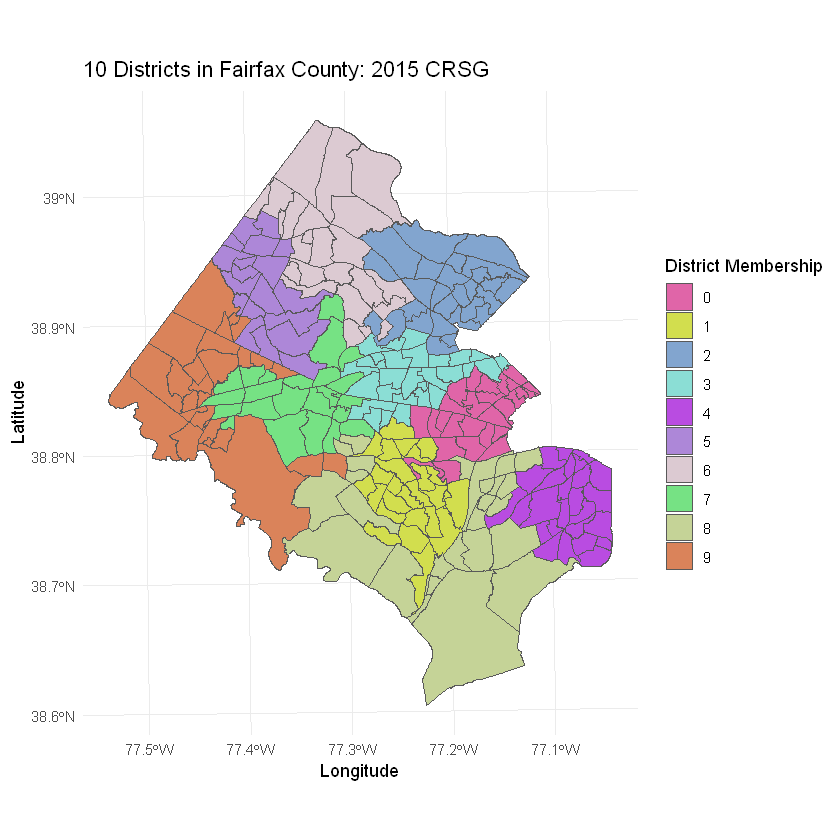

In [19]:
cds <- crsg_out$district_membership
plot <- redist.map(shp=df, 
        district_membership=cds, 
        centroids=FALSE, 
        edges=FALSE,
        title="10 Districts in Fairfax County: 2015 CRSG") +
        theme(legend.position="right") +
        scale_fill_manual(values = colors)
        # geom_sf_label(aes(label = cds))
#ggsave("fairfax_10.png")
plot

Classes and Methods for R developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University
Simon Jackman
hurdle and zeroinfl functions by Achim Zeileis

Warning message in if (measure == "all") {:
"the condition has length > 1 and only the first element will be used"
Warning message in par(oldpar):
"graphical parameter "cin" cannot be set"
Warning message in par(oldpar):
"graphical parameter "cra" cannot be set"
Warning message in par(oldpar):
"graphical parameter "csi" cannot be set"
Warning message in par(oldpar):
"graphical parameter "cxy" cannot be set"
Warning message in par(oldpar):
"graphical parameter "din" cannot be set"
Warning message in par(oldpar):
"graphical parameter "page" cannot be set"


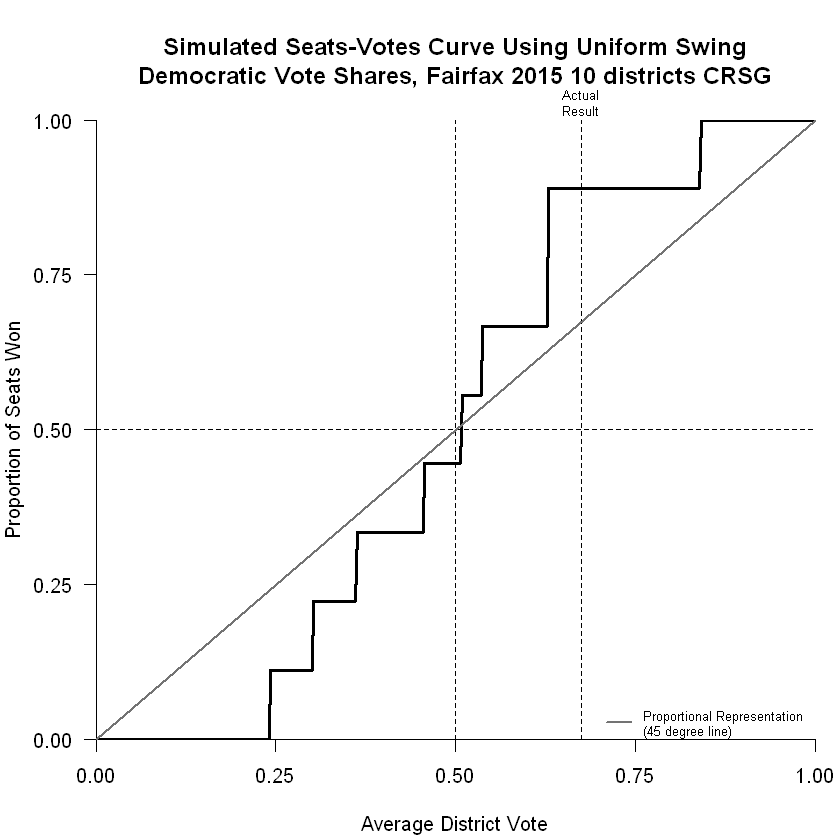

In [21]:
library(pscl)
# compute the percent of votes won by democrats in each district under DVS
plot_sv <- redist.metrics(cds, measure = c("DSeats", "DVS"), df$repvote, dvote = df$demvote) %>% 
           # extract DVS into vector
           pull(DVS) %>%
           # calculate seats-votes curve using uniform partisan swing
           seatsVotes(desc="Democratic Vote Shares, Fairfax 2015 10 districts CRSG") %>%
           # plot the seats-votes curve
           plot(type="seatsVotes")